This notebook analyze Brenchmark dataset with:
- FBCCA
- EEGnet

In [ ]:
!pip install mne
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu Jun 13 14:24:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   37C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Load data

In [ ]:
import numpy as np
import scipy.io

# read .mat data file
# used data of Subject1 for analysis
data_path = "/content/drive/MyDrive/datasets/Benchmark/"
filename = data_path + 'S1.mat'   # configurable -> modify to analyize other subject
file = scipy.io.loadmat(filename)
data = file['data']

# (n_channels, n_times, n_targets, n_blocks)
data.shape

(64, 1500, 40, 6)

## FBCCA

Reference Github: https://github.com/mnakanishi/TRCA-SSVEP

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 30 10:17:50 2019

@author: ALU

Steady-state visual evoked potentials (SSVEPs) detection using the filter
bank canonical correlation analysis (FBCCA)-based method [1].

function results = test_fbcca(eeg, list_freqs, fs, num_harms, num_fbs)

Input:
  eeg             : Input eeg data
                    (# of targets, # of channels, Data length [sample])
  list_freqs      : List for stimulus frequencies
  fs              : Sampling frequency
  num_harms       : # of harmonics
  num_fbs         : # of filters in filterbank analysis

Output:
  results         : The target estimated by this method

Reference:
  [1] X. Chen, Y. Wang, S. Gao, T. -P. Jung and X. Gao,
      "Filter bank canonical correlation analysis for implementing a
       high-speed SSVEP-based brain-computer interface",
      J. Neural Eng., vol.12, 046008, 2015.

"""
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
import warnings
import scipy.signal
import numpy as np


def filterbank(eeg, fs, idx_fb):
    if idx_fb == None:
        warnings.warn('stats:filterbank:MissingInput ' \
                      + 'Missing filter index. Default value (idx_fb = 0) will be used.')
        idx_fb = 0
    elif (idx_fb < 0 or 9 < idx_fb):
        raise ValueError('stats:filterbank:InvalidInput ' \
                         + 'The number of sub-bands must be 0 <= idx_fb <= 9.')

    if (len(eeg.shape) == 2):
        num_chans = eeg.shape[0]
        num_trials = 1
    else:
        num_chans, _, num_trials = eeg.shape

    # Nyquist Frequency = Fs/2N
    Nq = fs / 2

    passband = [6, 8, 10, 16, 22, 28, 34, 40]
    stopband = [4, 6,  6, 10, 16, 22, 28, 34]
    Wp = [passband[idx_fb] / Nq, 50 / Nq]
    Ws = [stopband[idx_fb] / Nq, 60 / Nq]
    [N, Wn] = scipy.signal.cheb1ord(Wp, Ws, 3, 40)  # band pass filter StopBand=[Ws(1)~Ws(2)] PassBand=[Wp(1)~Wp(2)]
    [B, A] = scipy.signal.cheby1(N, 0.5, Wn, 'bandpass')  # Wn passband edge frequency

    y = np.zeros(eeg.shape)
    if (num_trials == 1):
        for ch_i in range(num_chans):
            # apply filter, zero phass filtering by applying a linear filter twice, once forward and once backwards.
            # to match matlab result we need to change padding length
            y[ch_i, :] = scipy.signal.filtfilt(B, A, eeg[ch_i, :], padtype='odd', padlen=3 * (max(len(B), len(A)) - 1))

    else:
        for trial_i in range(num_trials):
            for ch_i in range(num_chans):
                y[ch_i, :, trial_i] = scipy.signal.filtfilt(B, A, eeg[ch_i, :, trial_i], padtype='odd',
                                                            padlen=3 * (max(len(B), len(A)) - 1))

    return y

def fbcca(data, list_freqs, fs, num_harms=3, num_fbs=5):

    fb_coefs = np.power(np.arange(1,num_fbs+1),(-1.25)) + 0.25

    num_targs = len(list_freqs)
    _, num_smpls = data.shape

    y_ref = cca_reference(list_freqs, fs, num_smpls, num_harms)
    cca = CCA(n_components=1) #initialize CCA

    # result matrix
    r = np.zeros((num_fbs,num_targs))

    for fb_i in range(num_fbs):  #filter bank number, deal with different filter bank
        testdata = filterbank(data, fs, fb_i)  #data after filtering
        for class_i in range(num_targs):
            refdata = np.squeeze(y_ref[class_i, :, :])   #pick corresponding freq target reference signal
            test_C, ref_C = cca.fit_transform(testdata.T, refdata.T)
            r_tmp, _ = pearsonr(np.squeeze(test_C), np.squeeze(ref_C)) #return r and p_value
            if r_tmp == np.nan:
                r_tmp=0
            r[fb_i, class_i] = r_tmp

    rho = np.dot(fb_coefs, r)  #weighted sum of r from all different filter banks' result
    print(rho) #print out the correlation
    result = np.argmax(rho)  #get maximum from the target as the final predict (get the index), and index indicates the maximum entry(most possible target)
    return result

'''
Generate reference signals for the canonical correlation analysis (CCA)
-based steady-state visual evoked potentials (SSVEPs) detection [1, 2].

function [ y_ref ] = cca_reference(listFreq, fs,  nSmpls, nHarms)

Input:
  listFreq        : List for stimulus frequencies
  fs              : Sampling frequency
  nSmpls          : # of samples in an epoch
  nHarms          : # of harmonics

Output:
  y_ref           : Generated reference signals
                   (# of targets, 2*# of channels, Data length [sample])

Reference:
  [1] Z. Lin, C. Zhang, W. Wu, and X. Gao,
      "Frequency Recognition Based on Canonical Correlation Analysis for
       SSVEP-Based BCI",
      IEEE Trans. Biomed. Eng., 54(6), 1172-1176, 2007.
  [2] G. Bin, X. Gao, Z. Yan, B. Hong, and S. Gao,
      "An online multi-channel SSVEP-based brain-computer interface using
       a canonical correlation analysis method",
      J. Neural Eng., 6 (2009) 046002 (6pp).
'''
def cca_reference(list_freqs, fs, num_smpls, num_harms=3):

    num_freqs = len(list_freqs)
    tidx = np.arange(1,num_smpls+1)/fs #time index

    y_ref = np.zeros((num_freqs, 2*num_harms, num_smpls))
    for freq_i in range(num_freqs):
        tmp = []
        for harm_i in range(1,num_harms+1):
            stim_freq = list_freqs[freq_i]  #in HZ
            # Sin and Cos
            tmp.extend([np.sin(2*np.pi*tidx*harm_i*stim_freq),
                       np.cos(2*np.pi*tidx*harm_i*stim_freq)])
        y_ref[freq_i] = tmp # 2*num_harms because include both sin and cos

    return y_ref

In [ ]:
# reshape data to shape(n_blocks, n_targets, n_channels, n_times)
# (64, 1500, 40, 6) -> (6, 40, 64, 1500)
data_ana = np.transpose(data, (3, 2, 0, 1))

list_freqs = [round(8 + 0.2 * x,1) for x in range(40)]
# 9 chaneels (Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2) are used for analysis in original dataset paper
ch_used = [54, 55, 56, 57, 58, 61, 62, 63]
fs = 250 # Hz
data_len = 5 # sec

results = []
for block_i in range(6):
    results.append(fbcca(data_ana[block_i][:,ch_used,int(fs*0.5):int(fs*0.5+data_len*fs)],list_freqs=list_freqs, fs = fs))

### Analysis result

In [ ]:
# print out result of first block
for i, res in enumerate(results[0]):
    print(f'{list_freqs[int(res)]:5.1f}',end=' ')
    if (i+1) % 8 == 0:
        print()

  8.0   9.0  10.0  11.0  12.0  13.0  14.0  15.0 
  8.2   9.2  10.2  11.2  12.2  13.2  14.2  15.2 
  8.4   9.4  10.4  11.4  12.4  13.4  10.4  15.4 
  8.6   9.6  10.6  11.6  12.6  13.6  14.6  10.4 
  8.8   9.8  10.8  11.8  12.8  13.8  14.8  15.8 


### Actual Frequency

In [ ]:
freq_a = [8 + x // 8 * 0.2 + x % 8 * 1 for x in range(40)]
# print out actual stimulus frequency
for i, freq in enumerate(freq_a):
    print(f'{freq:5.1f}',end=' ')
    if (i+1) % 8 == 0:
        print()

  8.0   9.0  10.0  11.0  12.0  13.0  14.0  15.0 
  8.2   9.2  10.2  11.2  12.2  13.2  14.2  15.2 
  8.4   9.4  10.4  11.4  12.4  13.4  14.4  15.4 
  8.6   9.6  10.6  11.6  12.6  13.6  14.6  15.6 
  8.8   9.8  10.8  11.8  12.8  13.8  14.8  15.8 


In [ ]:
# number of misclassification
mis_cnt = 0

for block_i in range(6):
    for target_i in range(40):
        if list_freqs[int(results[block_i][target_i])] != freq_a[target_i]:
            mis_cnt += 1

mis_cnt

24

In [ ]:
print(f"FBCCA Classification Accuracy: {1-(mis_cnt/240):.2%}")

FBCCA Classification Accuracy: 90.00%


# EEGnet

## Load data

In [ ]:
import scipy.io
import numpy as np

# Load all subject
raw_data = []

for subject_i in range(35):
    data_path = "/content/drive/MyDrive/datasets/Benchmark/"
    filename = data_path + 'S'+str(subject_i+1)+'.mat'
    file = scipy.io.loadmat(filename)
    subject_data = file['data'].astype(np.float32)
    raw_data.append(subject_data)

raw_data_array = np.array(raw_data)
#del raw_data

In [ ]:
raw_data_array.shape

(35, 64, 1500, 40, 6)

## Data length 1 sec

- Using data stimulated by four frequencies: 8, 9, 10, and 11 Hz.
- 35 participants are divided into three groups for training, validation, and - testing, with 21, 7, and 7 participants respectively.
- Use one second of data, taking segments from each trial starting from 0.5 seconds to 5.5 seconds, with each trial being divided into five segments.

### Process data

Data format:

Datatype - float32 (both X and Y)  
X.shape - (#samples, 1, #timepoints, #channels)  
Y.shape - (#samples)

In [ ]:
# use only 8, 9, 10, 11 Hz
selected_targets = raw_data_array[:, :, :, :4, :]

# initial label
labels = np.array([8, 9, 10, 11])

num_subjects = raw_data_array.shape[0]  # 35
num_sessions = raw_data_array.shape[4]  # 6
full_labels = np.tile(labels, (num_subjects, num_sessions, 1)).transpose(0, 2, 1)

del raw_data_array

train_data = selected_targets[:21]
val_data = selected_targets[21:28]
test_data = selected_targets[28:]

train_labels = full_labels[:21]
val_labels = full_labels[21:28]
test_labels = full_labels[28:]

In [ ]:
train_data.shape

(21, 64, 1500, 4, 6)

In [ ]:
def reshape_data(data, labels):
    num_samples, num_channels, num_timepoints, num_targets, num_sessions = data.shape
    data_reshaped = data.transpose(0, 3, 4, 1, 2).reshape(num_samples * num_targets * num_sessions, 1, num_timepoints, num_channels)

    labels_reshaped = labels.reshape(-1)

    return data_reshaped, labels_reshaped

train_data_reshaped, train_labels_reshaped = reshape_data(train_data, train_labels)
val_data_reshaped, val_labels_reshaped = reshape_data(val_data, val_labels)
test_data_reshaped, test_labels_reshaped = reshape_data(test_data, test_labels)

In [ ]:
def segment_data_reshaped(data, labels):
    segmented_data = []
    segmented_labels = []
    start_sample = int(0.5 * 250)  # start at 0.5 sec
    for segment in range(5):  # 1 sec -> 5 segments
        segment_start = start_sample + segment * 250
        segment_end = segment_start + 250
        segmented_data.append(data[:, :, segment_start:segment_end, :])
        segmented_labels.append(labels)

    return np.array(segmented_data), np.array(segmented_labels)

segmented_train_data, segmented_train_labels = segment_data_reshaped(train_data_reshaped, train_labels_reshaped)
segmented_val_data, segmented_val_labels = segment_data_reshaped(val_data_reshaped, val_labels_reshaped)
segmented_test_data, segmented_test_labels = segment_data_reshaped(test_data_reshaped, test_labels_reshaped)

_, _, _, num_timepoints, num_channels = segmented_train_data.shape
X_train = segmented_train_data.reshape(-1, 1, num_timepoints, num_channels)
y_train = segmented_train_labels.reshape(-1)

X_val = segmented_val_data.reshape(-1, 1, num_timepoints, num_channels)
y_val = segmented_val_labels.reshape(-1)

X_test = segmented_test_data.reshape(-1, 1, num_timepoints, num_channels)
y_test = segmented_test_labels.reshape(-1)

In [ ]:
def label_adjust(labels):
    for i in range(len(labels)):
        if labels[i] == 8:
            labels[i] = 0
        elif labels[i] == 9:
            labels[i] = 1
        elif labels[i] == 10:
            labels[i] = 2
        elif labels[i] == 11:
            labels[i] = 3
    return labels

y_train = label_adjust(y_train)
y_val = label_adjust(y_val)
y_test = label_adjust(y_test)

from tensorflow.keras.utils import to_categorical

# Example
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [ ]:
X_train.shape

(2520, 1, 250, 64)

### EEGnet evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, Dropout, Flatten, ReLU, MaxPooling2D, Reshape, Permute

from tensorflow.keras.layers import Activation

def EEGNet(input_shape=(1, 250, 64)):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (1, 64), padding='valid', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = ReLU()(x)
    x = Permute((3, 2, 1))(x)

    x = tf.pad(x, paddings=tf.constant([[0, 0], [16, 17], [0, 1], [0, 0]]), mode="CONSTANT")
    x = Conv2D(4, (2, 32), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 4))(x)

    x = tf.pad(x, paddings=tf.constant([[0, 0], [2, 1], [4, 3], [0, 0]]), mode="CONSTANT")
    x = Conv2D(4, (8, 4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 4))(x)

    x = Flatten()(x)
    x = Dense(4)(x)  # Change the number of output units to 4 for 4 classes
    x = Activation('softmax')(x)  # Use softmax activation

    model = Model(inputs=inputs, outputs=x)
    return model

model = EEGNet()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_val, y_val), verbose=2)

# evaluate model
scores = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {scores[1]}")


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1, 250, 64)]      0         
                                                                 
 conv2d_36 (Conv2D)          (None, 1, 187, 16)        65536     
                                                                 
 batch_normalization_36 (Ba  (None, 1, 187, 16)        64        
 tchNormalization)                                               
                                                                 
 dropout_36 (Dropout)        (None, 1, 187, 16)        0         
                                                                 
 re_lu_36 (ReLU)             (None, 1, 187, 16)        0         
                                                                 
 permute_12 (Permute)        (None, 16, 187, 1)        0         
                                                          

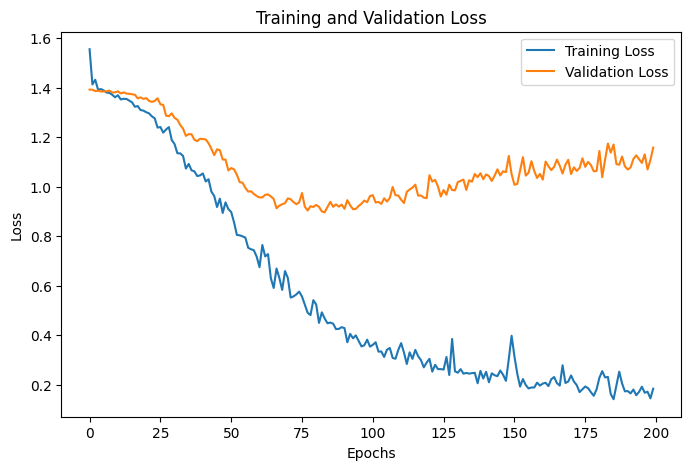

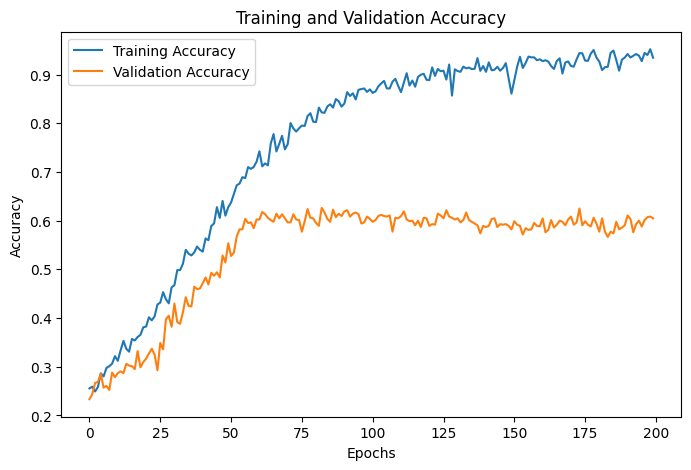

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

27/27 [==============================] - 0s 2ms/step


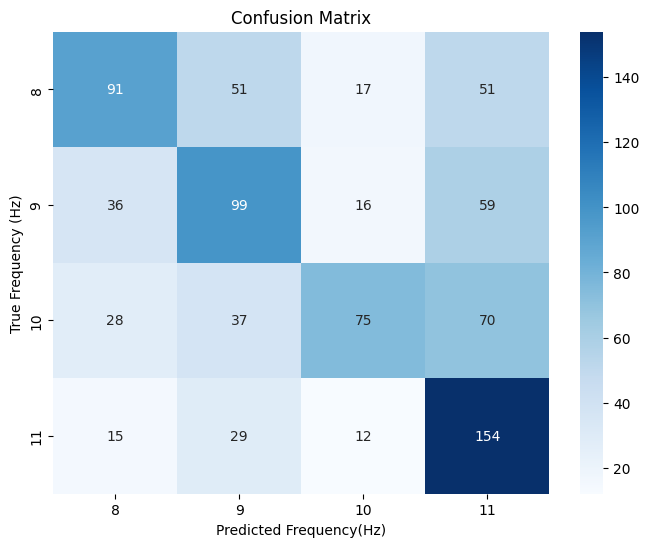

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

class_labels = [8, 9, 10, 11]

# calculate confusion_matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Frequency(Hz)')
plt.ylabel('True Frequency (Hz)')
plt.show()

## Data length 2.5 sec

- Using data stimulated by four frequencies: 8, 9, 10, and 11 Hz.
- 35 participants are divided into three groups for training, validation, and - testing, with 21, 7, and 7 participants respectively.
- Use 2.5 second of data, taking segments from each trial starting from 0.5 seconds to 5.5 seconds, with each trial being divided into two segments.

### Process data

Data format:

Datatype - float32 (both X and Y)  
X.shape - (#samples, 1, #timepoints, #channels)  
Y.shape - (#samples)

In [ ]:
# use only 8, 9, 10, 11 Hz
selected_targets = raw_data_array[:, :, :, :4, :]

# initial label
labels = np.array([8, 9, 10, 11])

num_subjects = raw_data_array.shape[0]  # 35
num_sessions = raw_data_array.shape[4]  # 6
full_labels = np.tile(labels, (num_subjects, num_sessions, 1)).transpose(0, 2, 1)

del raw_data_array

train_data = selected_targets[:21]
val_data = selected_targets[21:28]
test_data = selected_targets[28:]

train_labels = full_labels[:21]
val_labels = full_labels[21:28]
test_labels = full_labels[28:]

In [ ]:
train_data.shape

(21, 64, 1500, 4, 6)

In [ ]:
def reshape_data(data, labels):
    num_samples, num_channels, num_timepoints, num_targets, num_sessions = data.shape
    data_reshaped = data.transpose(0, 3, 4, 1, 2).reshape(num_samples * num_targets * num_sessions, 1, num_timepoints, num_channels)

    labels_reshaped = labels.reshape(-1)

    return data_reshaped, labels_reshaped

train_data_reshaped, train_labels_reshaped = reshape_data(train_data, train_labels)
val_data_reshaped, val_labels_reshaped = reshape_data(val_data, val_labels)
test_data_reshaped, test_labels_reshaped = reshape_data(test_data, test_labels)

In [ ]:
def segment_data_reshaped(data, labels):
    segmented_data = []
    segmented_labels = []
    start_sample = int(0.5 * 250)  # start at 0.5 sec
    for segment in range(2):  # 2.5 sec -> 2 segments
        segment_start = start_sample + segment * 625
        segment_end = segment_start + 625
        segmented_data.append(data[:, :, segment_start:segment_end, :])
        segmented_labels.append(labels)

    return np.array(segmented_data), np.array(segmented_labels)

segmented_train_data, segmented_train_labels = segment_data_reshaped(train_data_reshaped, train_labels_reshaped)
segmented_val_data, segmented_val_labels = segment_data_reshaped(val_data_reshaped, val_labels_reshaped)
segmented_test_data, segmented_test_labels = segment_data_reshaped(test_data_reshaped, test_labels_reshaped)

_, _, _, num_timepoints, num_channels = segmented_train_data.shape
X_train = segmented_train_data.reshape(-1, 1, num_timepoints, num_channels)
y_train = segmented_train_labels.reshape(-1)

X_val = segmented_val_data.reshape(-1, 1, num_timepoints, num_channels)
y_val = segmented_val_labels.reshape(-1)

X_test = segmented_test_data.reshape(-1, 1, num_timepoints, num_channels)
y_test = segmented_test_labels.reshape(-1)

In [ ]:
X_test.shape

(336, 1, 625, 64)

In [ ]:
def label_adjust(labels):
    for i in range(len(labels)):
        if labels[i] == 8:
            labels[i] = 0
        elif labels[i] == 9:
            labels[i] = 1
        elif labels[i] == 10:
            labels[i] = 2
        elif labels[i] == 11:
            labels[i] = 3
    return labels

y_train = label_adjust(y_train)
y_val = label_adjust(y_val)
y_test = label_adjust(y_test)

from tensorflow.keras.utils import to_categorical

# Example
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [ ]:
X_train.shape

(1008, 1, 625, 64)

### EEGnet evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, Dropout, Flatten, ReLU, MaxPooling2D, Reshape, Permute

from tensorflow.keras.layers import Activation

def EEGNet(input_shape=(1, 625, 64)):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (1, 64), padding='valid', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = ReLU()(x)
    x = Permute((3, 2, 1))(x)

    x = tf.pad(x, paddings=tf.constant([[0, 0], [16, 17], [0, 1], [0, 0]]), mode="CONSTANT")
    x = Conv2D(4, (2, 32), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 4))(x)

    x = tf.pad(x, paddings=tf.constant([[0, 0], [2, 1], [4, 3], [0, 0]]), mode="CONSTANT")
    x = Conv2D(4, (8, 4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 4))(x)

    x = Flatten()(x)
    x = Dense(4)(x)  # Change the number of output units to 4 for 4 classes
    x = Activation('softmax')(x)  # Use softmax activation

    model = Model(inputs=inputs, outputs=x)
    return model

model = EEGNet()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_val, y_val), verbose=2)

# evaluate model
scores = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {scores[1]}")


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1, 625, 64)]      0         
                                                                 
 conv2d_30 (Conv2D)          (None, 1, 562, 16)        65536     
                                                                 
 batch_normalization_30 (Ba  (None, 1, 562, 16)        64        
 tchNormalization)                                               
                                                                 
 dropout_30 (Dropout)        (None, 1, 562, 16)        0         
                                                                 
 re_lu_30 (ReLU)             (None, 1, 562, 16)        0         
                                                                 
 permute_10 (Permute)        (None, 16, 562, 1)        0         
                                                          

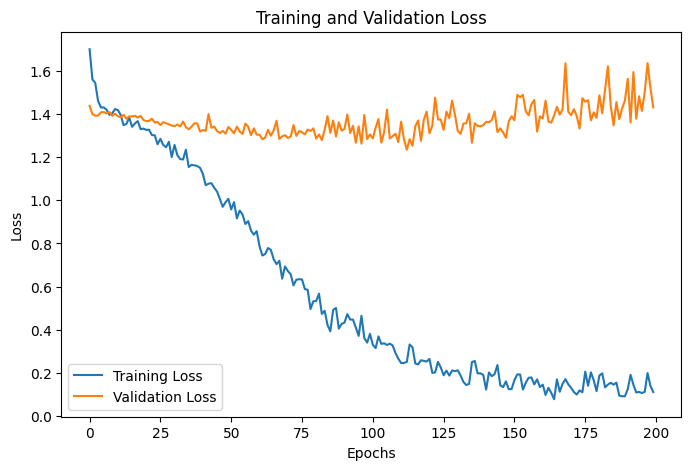

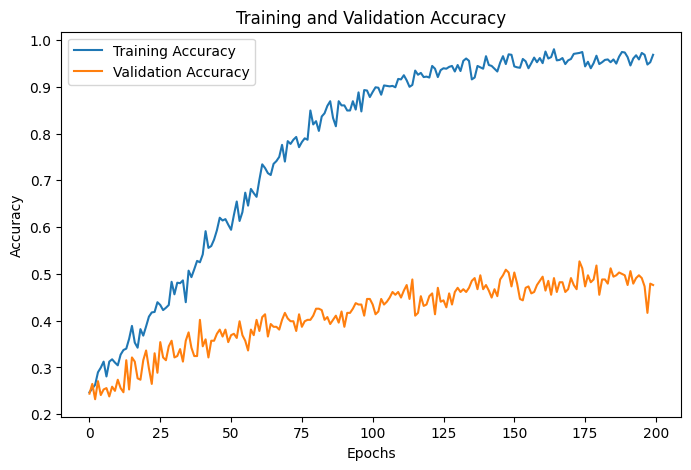

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


11/11 [==============================] - 0s 3ms/step


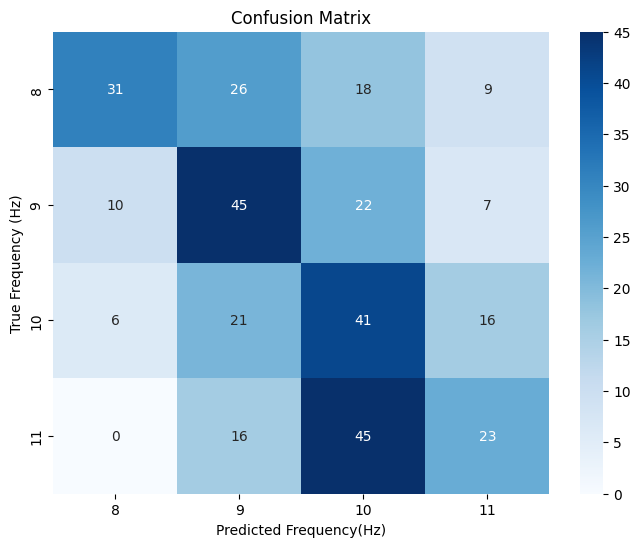

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

class_labels = [8, 9, 10, 11]

# calculate confusion_matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Frequency(Hz)')
plt.ylabel('True Frequency (Hz)')
plt.show()